# ESiWACE3 Compression Lab in WebAssembly

**Note:** Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

**Note:** The WASM-based version of the compression lab running inside JupyterLite has only been tested in recent Chrome and Firefox browsers.

## Import the ESiWACE3 field compression lab library

Importing `fcpy` also imports a large number of dependencies, which may take around a minute. Why not use this time to grab a drink, stretch your legs, and look out of your window?

In [1]:
import fcpy

Many Python packages that are common in scientific computing and meteorology are available in this lab and can simply be imported. These include, e.g., `cartopy`, `cfgrib`, `dask`, `matplotlib`, `metpy`, `netcdf4`, `numcodecs`, `numpy`, `pandas`, `xarray`, and `zarr`.

If you want to use a package that fails to import, you can first try to install it from PyPi by running a code cell similar to the following, which installs `tqdm`:

In [2]:
%pip install tqdm
import tqdm

Note that this installation only works for *pure* Python packages, i.e. those that only include Python code and only have pure or pre-installed dependencies. If you cannot install your packages this way, please tell us about the missing package in the feedback form below:

https://forms.office.com/e/hKqfmvFTkz

## Fetch an example dataset

### (a) Download a small dataset into memory

Small datasets can be downloaded and saved in the in-memory file system of this JupyterLite notebook. Note, however, that memory is limited.

In [3]:
small_path = fcpy.fetch_small_http_file(
    "https://esiwace3-compression-lab.onrender.com/data/hplp_ml_q_dx=2.0.grib"
)
small_path

PosixPath('/scratch/384e8286-3c8d-44a5-97ce-7db1fd2cfdc1/hplp_ml_q_dx=2.0.grib')

### (b) Mount a large dataset from the user's filesystem

Alternatively, you can also upload a dataset file from your own computer. The file is mounted in read-only mode into the notebook's file system without reading the file into memory, thus allowing arbitrarily large files to be made accessible. It is worth remembering that large files can still only be read if the algorithm that processes them supports streaming or chunking and does not request to load all data into memory at the same time.

If this notebook is run inside JupyterLite, the file also never leaves your own computer.

Note that this code is commented out since it requires your user input to upload a file and progress through the code. To mount an uploaded file, uncomment the following code cell and run it.

In [4]:
# upload_path = await fcpy.mount_user_local_file()
# upload_path

Once you have selected a file to upload, you can retrieve the path at which the file is now mounted in read-only mode.

### (c) Mount a large dataset from a URL that supports HTTP Range Requests

Similarly, you can also mount a file from a URL. The file is mounted in read-only mode into the notebook's file system without reading the file into memory, thus allowing arbitrarily large files to be made accessible.

Note that the HTTP endpoint at the URL must support [range requests](https://developer.mozilla.org/en-US/docs/Web/HTTP/Range_requests) and serve the file without compression so that small chunks of the file can be loaded only when requested. If the dataset is hosted at a different HTTP [origin](https://developer.mozilla.org/en-US/docs/Glossary/Origin) than this compression lab, it must also support [Cross-Origin Resource Sharing](https://developer.mozilla.org/en-US/docs/Web/HTTP/CORS).

It is also worth remembering that large files can still only be read if the algorithm that processes them supports streaming or chunking and does not request to load all data into memory at the same time.

In [5]:
http_path = fcpy.mount_http_file(
    "https://esiwace3-compression-lab.onrender.com/data/hplp_ml_q_dx=2.0.grib"
)
http_path

PosixPath('/http/b9f41fba-406a-4a17-98ec-b68fb4f12359/hplp_ml_q_dx=2.0.grib')

## Load the example dataset into `xarray`

To select which dataset you wish to load, only execute one of the following three lines.

Afterwards, we load the dataset into `xarray`.
```python
fcpy.open_dataset(path: pathlib.Path, **kwargs) -> xarray.Dataset
```
is a thin wrapper around
```python
xarray.open_dataset(filename: str, **kwargs) -> xarray.Datset
```
and thus takes the same arguments. Please refer to the [`xarray.open_dataset`](https://docs.xarray.dev/en/stable/generated/xarray.open_dataset.html) documentation if you need to perform some special configuration.

In [6]:
dataset_path = small_path
# dataset_path = upload_path
# dataset_path = http_path

ds = fcpy.open_dataset(dataset_path)
ds

<xarray.Dataset>
Dimensions:     (hybrid: 10, latitude: 91, longitude: 180)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * latitude    (latitude) float64 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * longitude   (longitude) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
    valid_time  datetime64[ns] ...
Data variables:
    q           (hybrid, latitude, longitude) float64 dask.array<chunksize=(10, 91, 180), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-07-06T13:13 GRIB to CDM+CF via cfgrib-0.9.1...
    path:                    /scratch/384e8286-3c8d-44a5-97ce-7db1fd2cfdc1/hp...

## Plot the loaded dataset

We first plot the loaded dataset. `fcpy` provides the
```python
fcpy.suite.plot_spatial_dataarray(
    da: xr.DataArray,
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]
```
helper function to plot spatial data. Note that this function requires that the data array is gridded along the standard "latitude" and "longitude" axes.

/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


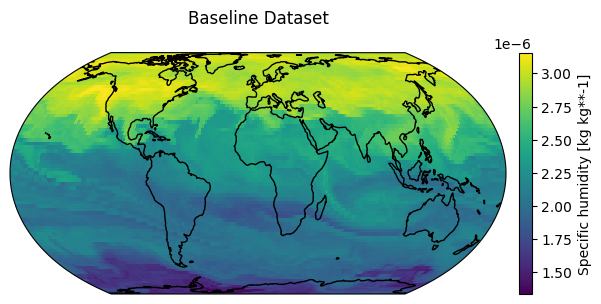

In [7]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds["q"].sel(dict(hybrid=1)),
)
ax.set_title("Baseline Dataset\n");

## Run a simple Linear Quantization compressor

`fcpy` provides some helper functions to compress your data with codecs implementing the `numcodecs` API. `fcpy.codecs` further contains some additional codecs, including the simple lossy `LinearQuantize` codec that rescales real-valued data from $[min; max]$ to the integer range $[0; 2^b - 1]$. Here, $b$ is the number of bit precision you want to keep.

In [8]:
simple_compressor = fcpy.codecs.LinearQuantize(bits=4, dtype="float64")
ds_simple = fcpy.suite.compress_decompress_dataset(ds, simple_compressor, experiment="simple-{}")

Note that compression in `fcpy` is lazy and does not happen until the result is required to be computed. This lazy and chunked computation allows you to experiment with datasets that would not fit into memory otherwise. Therefore, you can only measure the compression ratio and speed using
```python
with fcpy.measure_compression_stats() as stats:
    # access the compressed data here
```
when the compressed-decompressed dataset data is accessed, e.g. during plotting.

,,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [dec GB/s]
Experiment,Codec,,,
simple-q,"LinearQuantize(bits=4, dtype='<f8')",7.998779,0.297818,0.728


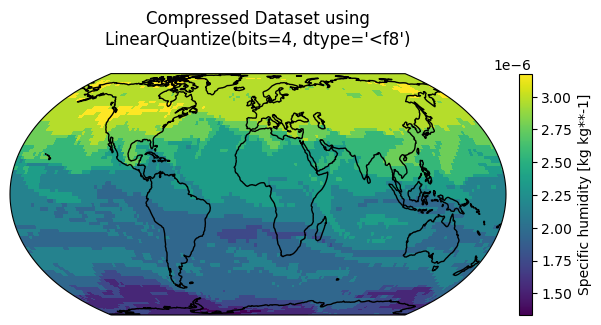

In [9]:
with fcpy.measure_compression_stats() as stats:
    fig, ax = fcpy.suite.plot_spatial_dataarray(
        ds_simple["q"].sel(dict(hybrid=1)),
    )
    ax.set_title(f"Compressed Dataset using\n{simple_compressor}\n")
stats

With the above code, the compression statistics are only measured on the data that is needed, here for plotting. You can also perform the measurements across the entire dataset with the
```python
fcpy.chunked_compute_sink(dsa: Union[xr.Dataset, xr.DataArray])
```
helper function:

In [10]:
with fcpy.measure_compression_stats() as stats:
    fcpy.chunked_compute_sink(ds_simple)
stats

,,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [dec GB/s]
Experiment,Codec,,,
simple-q,"LinearQuantize(bits=4, dtype='<f8')",7.998779,0.289912,0.78


## Plot the simple compression error

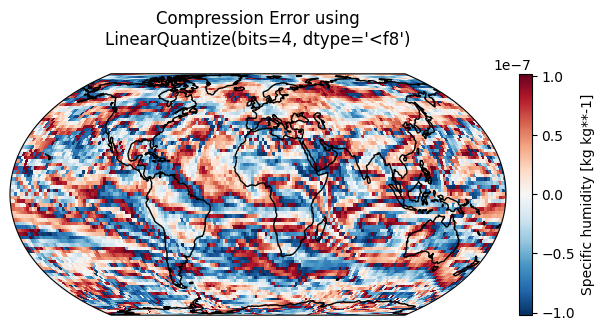

In [11]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds.copy(data=(ds_simple - ds))["q"].sel(dict(hybrid=1)),
)
ax.set_title(f"Compression Error using\n{simple_compressor}\n");

## Run the transform-based ZFP compressor

ZFP is a lossy transform-based compressor that compresses multidimensional data in $4^d$ chunks where $d$ is the dimensionality of the data. All values in the chunk are decorrelated and then transformed into a binary plane embedding that is roughly ordered by importance. The resulting per-chunk bitstream can be truncated to satisfy a user-provided compression target, e.g. a fixed number of bits, a bitplane precision, or an absolute error tolerance.

You can find out more about the ZFP compressor in its [documentation](https://zfp.readthedocs.io/en/latest/index.html) and the following two publications:

> Diffenderfer, J. et *al*. (2019). Error Analysis of ZFP Compression for Floating-Point Data. *SIAM Journal on Scientific Computing*. 41(3). pp. A1867-A1898. Available from: [doi:10.1137/18M1168832](https://doi.org/10.1137/18M1168832).

> Lindstrom, P. (2014). Fixed-Rate Compressed Floating-Point Arrays. *IEEE Transactions on Visualization and Computer Graphics*. 20(2). pp. 2674-2683. Available from: [doi:10.1109/TVCG.2014.2346458](https://doi.org/10.1109/TVCG.2014.2346458).

In [12]:
import numcodecs
import zfpy

transform_compressor = numcodecs.ZFPY(mode=zfpy.mode_fixed_accuracy, tolerance=1e-8)
ds_transform = fcpy.suite.compress_decompress_dataset(ds, transform_compressor, experiment="zfp-{}")

,,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [dec GB/s]
Experiment,Codec,,,
zfp-q,"ZFPY(mode=4, tolerance=1e-08, rate=-1, precision=-1)",6.488157,0.070756,0.083678


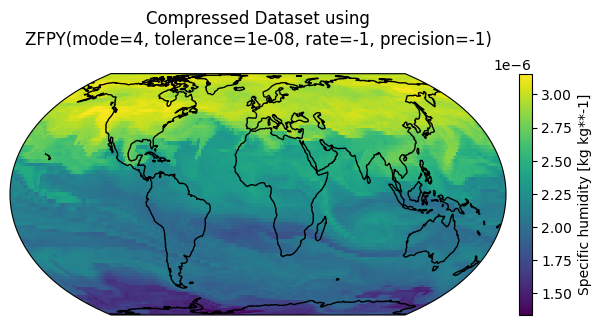

In [13]:
with fcpy.measure_compression_stats() as stats:
    fig, ax = fcpy.suite.plot_spatial_dataarray(
        ds_transform["q"].sel(dict(hybrid=1)),
    )
    ax.set_title(f"Compressed Dataset using\n{transform_compressor}\n");
stats

## Plot the ZFP compression error

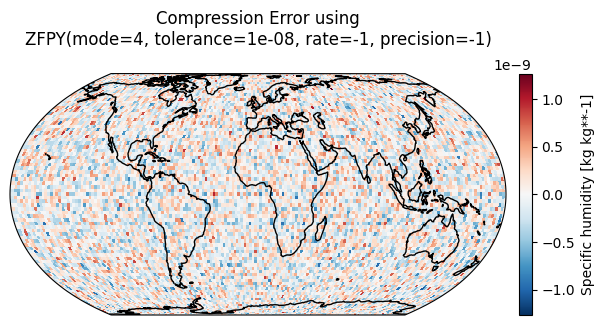

In [14]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds.copy(data=(ds_transform - ds))["q"].sel(dict(hybrid=1)),
)
ax.set_title(f"Compression Error using\n{transform_compressor}\n");

## Run the prediction-based SZ3 compressor

SZ3 is a lossy prediction-based compressor that compresses multidimensional data by predicting the next value based on an indentified pattern. The quantized prediction errors are stored alongside the pattern. SZ3 is a modular compression pipeline that combines a data preprocessor, predictor, quantizer, encoder, and lossless compressor. The compression error can be bounded with absolute, relative, and PWR error bounds.

You can find out more about the SZ3 compressor in the following publications:

> Liang, X. et *al*. (2023). SZ3: A modular framework for composing prediction-based error-bounded lossy compressors. *IEEE Transactions on Big Data*. 9(2). pp. 485-498. Available from: [doi:10.1109/TBDATA.2022.3201176](https://doi.org/10.1109/TBDATA.2022.3201176).

> Zhao, K. et *al*. (2021). Optimizing Error-Bounded Lossy Compression for Scientiﬁc Data by Dynamic Spline Interpolation. In: *Proceeding of the 37th IEEE International Conference on Data Engineering*. pp. 1643-1654. Available from: [doi:10.1109/ICDE51399.2021.00145](https://doi.org/10.1109/ICDE51399.2021.00145).

> Liang, X. et *al*. (2018). Error-Controlled Lossy Compression Optimized for High Compression Ratios of Scientific Datasets. *IEEE International Conference on Big Data*. pp. 438-447. Available from: [doi:10.1109/BigData.2018.8622520](https://doi.org/10.1109/BigData.2018.8622520).

In [15]:
import pysz

predict_compressor = fcpy.codecs.SZ3(dtype="float64", eb_mode=pysz.mode_abs, eb_abs=1e-8)
ds_predict = fcpy.suite.compress_decompress_dataset(ds, predict_compressor, experiment="sz3-{}")

,,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [dec GB/s]
Experiment,Codec,,,
sz3-q,"SZ3(dtype='<f8', eb_mode=0, eb_abs=1e-08, eb_rel=0.0, eb_pwr=0.0)",24.363217,0.015705,0.030152


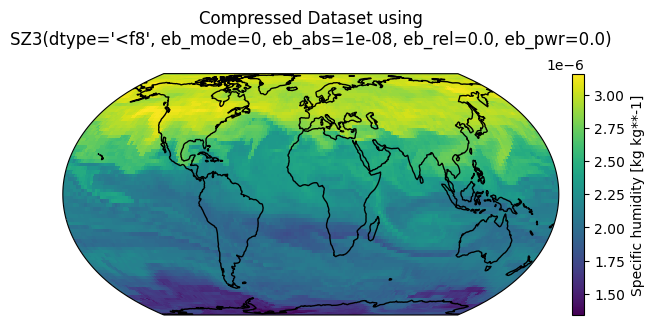

In [16]:
with fcpy.measure_compression_stats() as stats:
    fig, ax = fcpy.suite.plot_spatial_dataarray(
        ds_predict["q"].sel(dict(hybrid=1)),
    )
    ax.set_title(f"Compressed Dataset using\n{predict_compressor}\n");
stats

## Plot the SZ3 compression error

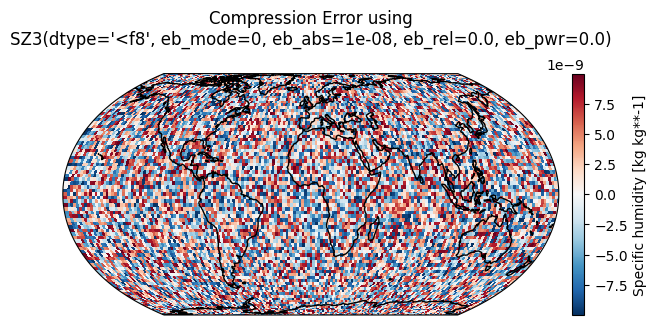

In [17]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds.copy(data=(ds_predict - ds))["q"].sel(dict(hybrid=1)),
)
ax.set_title(f"Compression Error using\n{predict_compressor}\n");

## Save the dataset for further use

If you want to perform further work on the (compressed) data outside or in a new session of the compression lab, you can download the data to your computer. Note that the writes are directly streamed to the download and it is thus not possible to skip around the file (seek) or read written back during the download.

### (a) Download the compressed data

You can save the compressed dataset as a single `.zip` file in the [ZARR format](https://zarr.readthedocs.io/en/stable/spec.html). Note that this approach takes the uncompressed dataset and runs the provided compression as the dataset is downloaded.

For instance, here we download the dataset compressed using the SZ3 compressor from above. You can also download the uncompressed dataset by passing `compressor=[]` to the following helper function:
```python
await fcpy.download_dataset_as_zarr(
    ds: xr.Dataset,
    name: str,
    compressor: Union[
        numcodecs.abc.Codec,
        list[numcodecs.abc.Codec],
        dict[str, Union[
            numcodecs.abc.Codec,
            list[numcodecs.abc.Codec],
        ]],
    ],
    zip_compression: int = 0,
)
```

In [18]:
from pathlib import Path

compressed_download_name = Path(ds.attrs.get("path", "ds")).name
compressed_download_name = compressed_download_name[:compressed_download_name.find('.')]
compressed_download_name = f"{compressed_download_name}-compressed.zarr.zip"
compressed_download_name

'hplp_ml_q_dx=2-compressed.zarr.zip'

In [19]:
await fcpy.download_dataset_as_zarr(ds, compressed_download_name, compressor=predict_compressor)

### (b) Download arbitrary files

You can also download arbitrary files. The compression lab provides the following (asynchronous context manager) construct to obtain a file system path to which the to-be-downloaded file can be written inside the `async with` block:
```python
async with fcpy.file_download_path("my-file.txt") as download_path:
    with open(download_path, "w") as download:
        download.write("Hello world!")
```
Note again that the special download files do not provide random access but are append-only streams. Since, e.g. NetCDF file writes require random access, they cannot be directly downloaded but must go through a temporary file first (see option **(c)** below).

### (c) Download (small) files from the (in-memory) file system

If your file already exists within the file system, you can download them directly. For instance, you can download small files that are stored in the in-memory file system. If you want to download small files that need seeks or reads during writing, you can first write them to the in-memory file system and then download them.

For instance, here we create, write to, and then partially overwrite a text file, before we download it.

In [20]:
import io
import shutil

with open("demo.txt", "wb") as file:
    file.write(b"This text is wrong")
    file.seek(-len(b"wrong"), io.SEEK_CUR)
    file.write(b"correct")

async with fcpy.file_download_path("demo.txt") as download_path:
    shutil.copyfile("demo.txt", download_path)

## Feedback on the ESiWACE3 Compression Lab

We aim to build an online compression laboratory in which you can easily test and apply the most relevant compression algorithms on your data. We want to hear from you about what your requirements for compression are to ensure that any downstream scientific analysis is not adversely affected.

Please use the below link to provide us with feedback on
- your requirements for compression
- any bugs in the compression lab
- missing features that would allow you to better use it (e.g. unsupported data formats, compression methods, or compression error analysis methods)
- complicated or unclear functionality in the compression lab

https://forms.office.com/e/hKqfmvFTkz